<a href="https://colab.research.google.com/github/ShounakDas101/AIML_Hari/blob/main/ElectronPhotonClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import h5py
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import transforms
import torch.optim as optim

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os

# Specify the path to the file in your Google Drive
file_path = '/content/drive/MyDrive/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5'
CHECKPOINT_PATH = '/content/drive/MyDrive/CHECKPOINTS'

# Check if the file exists
if os.path.exists(file_path):
    print(f"The file '{file_path}' exists.")
else:
    print(f"The file '{file_path}' does not exist.")

The file '/content/drive/MyDrive/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5' exists.


In [4]:
# clearing cuda cache memory
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [5]:
import h5py

def find_keys(hdf5_obj, path='/'):
    """Recursively find keys in an HDF5 file."""
    keys = []
    for key in hdf5_obj[path].keys():
        full_path = f"{path}/{key}"
        keys.append(full_path)
        if isinstance(hdf5_obj[full_path], h5py.Group):
            keys.extend(find_keys(hdf5_obj, full_path))
    return keys

# Open the HDF5 file
file_path = '/content/drive/MyDrive/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5'  # Replace with your actual file path
with h5py.File(file_path, 'r') as hdf5_file:
    # Find keys starting from the root
    all_keys = find_keys(hdf5_file)

# Print the found keys
for key in all_keys:
    print(key)


//X
//y


In [6]:
# import dataset

# importing electron dataset and seperating images and labels
electron_dataset = h5py.File("/content/drive/MyDrive/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5","r")
electron_imgs=np.array(electron_dataset["X"])
electron_labels=np.array(electron_dataset["y"],dtype=np.int64)

# importing photon dataset and seperating images and labels
photon_dataset = h5py.File("/content/drive/MyDrive/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5","r")
photon_imgs=np.array(photon_dataset["X"])
photon_labels=np.array(photon_dataset["y"],dtype=np.int64)

In [7]:
print(electron_imgs.shape)
print(electron_labels)

(249000, 32, 32, 2)
[1 1 1 ... 1 1 1]


(249000, 32, 32, 2)


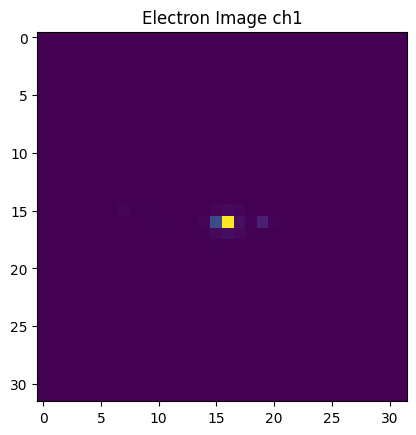

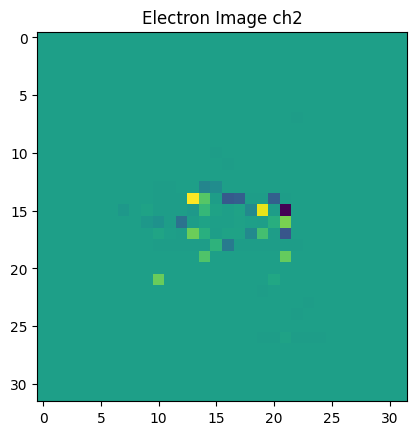

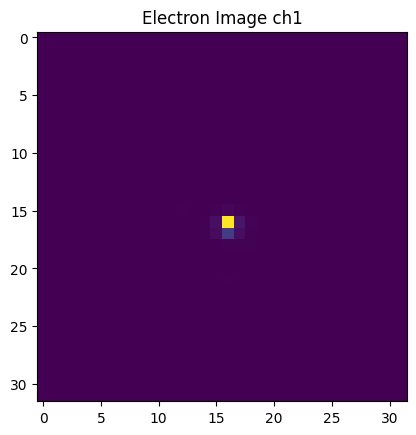

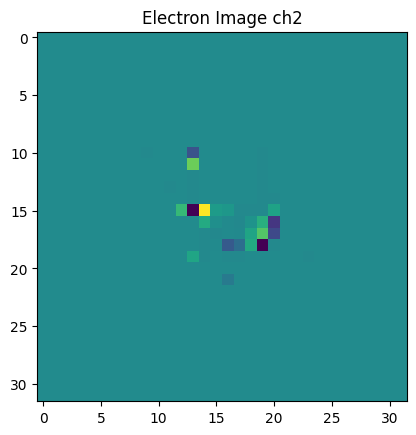

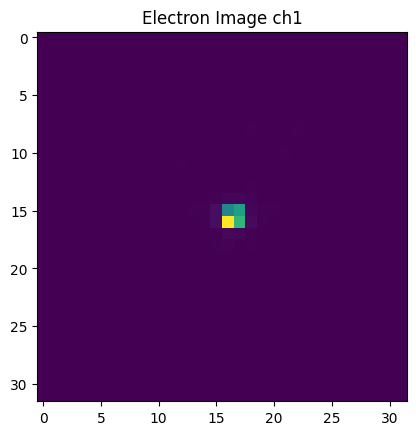

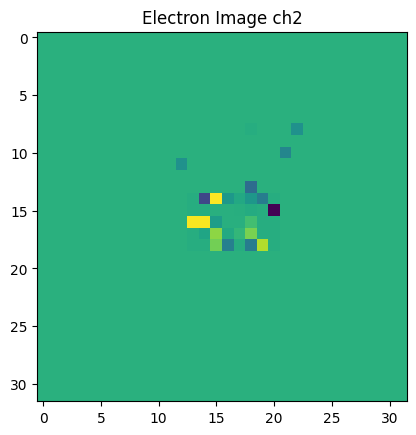

In [8]:
import matplotlib.pyplot as plt
print(electron_imgs.shape)
for electron_imgs1 in electron_imgs[:3]:
  # Display the first image from electron_imgs
  plt.imshow(electron_imgs1[:, :, 0])  # Assuming it's a 2-channel image; adjust if needed
  plt.title('Electron Image ch1')
  plt.show()

  # Display the first image from photon_imgs
  plt.imshow(electron_imgs1[:, :, 1])  # Assuming it's a 2-channel image; adjust if needed
  plt.title('Electron Image ch2')
  plt.show()



(249000, 32, 32, 2)


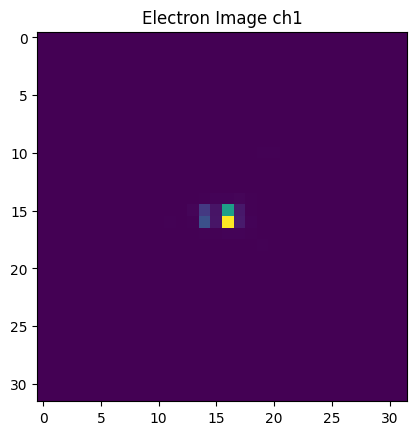

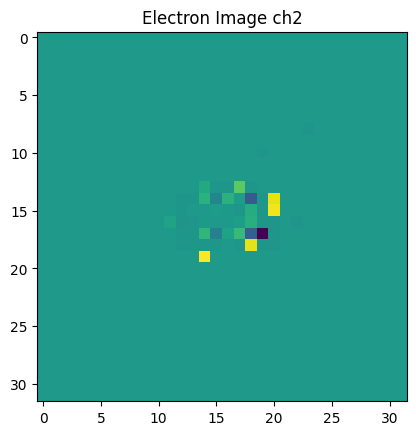

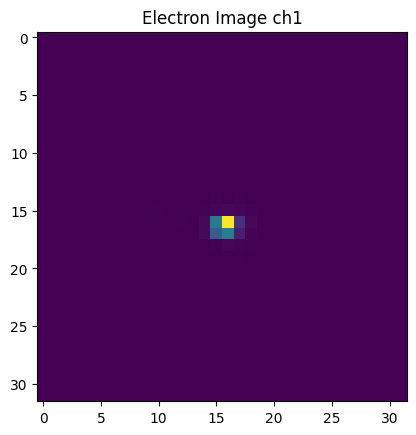

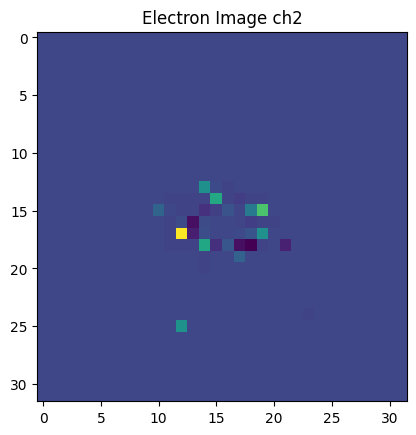

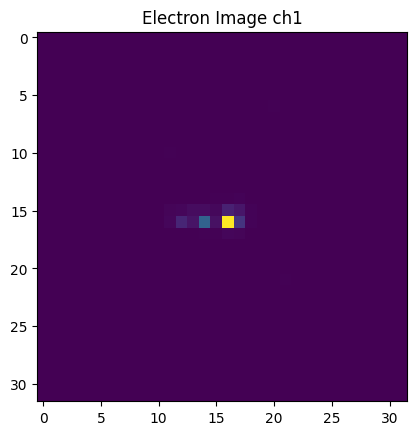

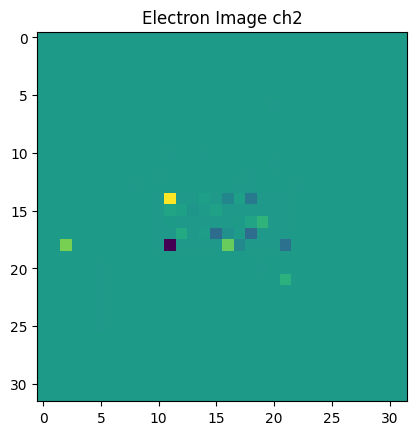

In [10]:
import matplotlib.pyplot as plt
print(electron_imgs.shape)
for photon_imgs1 in photon_imgs[:3]:
  # Display the first image from electron_imgs
  plt.imshow(photon_imgs1[:, :, 0])  # Assuming it's a 2-channel image; adjust if needed
  plt.title('Electron Image ch1')
  plt.show()

  # Display the first image from photon_imgs
  plt.imshow(photon_imgs1[:, :, 1])  # Assuming it's a 2-channel image; adjust if needed
  plt.title('Electron Image ch2')
  plt.show()



In [11]:
# concatenate electron and photon images/labels
img_arrs = torch.Tensor(np.vstack((photon_imgs,electron_imgs)))
labels = torch.Tensor(np.hstack((photon_labels,electron_labels))).to(torch.int64)
img_arrs = img_arrs.permute(0,3,1,2)
print(img_arrs.shape)

torch.Size([498000, 2, 32, 32])


In [12]:
del electron_imgs,photon_imgs,electron_labels,photon_labels

In [13]:
from torch.utils.data import Dataset, DataLoader, random_split

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'image': self.data[idx], 'label': self.labels[idx]}
        return sample

In [14]:
# Assuming img_arrs and labels are already defined
custom_dataset = CustomDataset(img_arrs, labels)

# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(custom_dataset))
valid_size = int(0.2 * len(custom_dataset))
test_size = len(custom_dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(custom_dataset, [train_size, valid_size, test_size])
print(len(valid_dataset)+len(test_dataset)+len(train_dataset))

498000


In [15]:
# Create DataLoaders for training, validation, and test sets
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs = next(iter(train_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs['image'].shape, "\n")
print("Full",data_inputs)

Data inputs torch.Size([64, 2, 32, 32]) 

Full {'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
        

In [17]:
my_conv1 = nn.Conv2d(in_channels=2, out_channels=32, kernel_size=3, padding=1)
output=my_conv1((data_inputs['image']))
print(output.shape)
relu = nn.ReLU()
output=output.view(batch_size,-1)
print(output.shape[0],output.shape[1])
fc = nn.Linear(output.shape[1],2)
fc(output)

torch.Size([64, 32, 32, 32])
64 32768


tensor([[ 0.0571, -0.1122],
        [ 0.0454, -0.1370],
        [ 0.0579, -0.1306],
        [ 0.0503, -0.1058],
        [ 0.0590, -0.1103],
        [ 0.0589, -0.1350],
        [ 0.0667, -0.1208],
        [ 0.0526, -0.1006],
        [ 0.0655, -0.1121],
        [ 0.0768, -0.1201],
        [ 0.0946, -0.1307],
        [ 0.0718, -0.1370],
        [ 0.0555, -0.1510],
        [ 0.0717, -0.1301],
        [ 0.0867, -0.1150],
        [ 0.0645, -0.1141],
        [ 0.0640, -0.1520],
        [ 0.0207, -0.1186],
        [ 0.0809, -0.1392],
        [ 0.0598, -0.1214],
        [ 0.0665, -0.1335],
        [ 0.0717, -0.1175],
        [ 0.0348, -0.1002],
        [ 0.0752, -0.1235],
        [ 0.0429, -0.1367],
        [ 0.0904, -0.1223],
        [ 0.0818, -0.1127],
        [ 0.0831, -0.1186],
        [ 0.0625, -0.1419],
        [ 0.0762, -0.1111],
        [ 0.0493, -0.1126],
        [ 0.0600, -0.1265],
        [ 0.0535, -0.1363],
        [ 0.0820, -0.1284],
        [ 0.0577, -0.1230],
        [ 0.0590, -0

In [22]:
class MyModel(nn.Module):

    def __init__(self, num_classes=1,dropout_rate=.2):
        super().__init__()
        self.my_conv1 = nn.Conv2d(in_channels=2, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.Linear=nn.Linear(32*32*32,num_classes)
    def forward(self, x):
        x['image']=self.my_conv1(x['image'])
        x['image']=self.relu(x['image'])
        x['image'] = self.dropout(x['image'])
        x['image']=x['image'].view(batch_size,-1)
        x['image'] = self.Linear(x['image'])
        return x['image']



In [23]:
model = MyModel(num_classes=1)
model.to(device)
print(model)

MyModel(
  (my_conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (Linear): Linear(in_features=32768, out_features=1, bias=True)
)


In [21]:
# i=0

# for batch_idx, batch in enumerate(train_loader):
#     # Process your batch here

#     # Check if the current batch is the last one
#     is_last_batch = batch['image'].shape[0] < batch_size

#     # Print information or perform actions based on whether it's the last batch
#     # print(f"Batch {batch_idx + 1}, Batch Size: {len(batch)}, Is Last Batch: {is_last_batch}")
#     if(is_last_batch):
#       break

#     # Continue processing the batch as needed
#     preds = model(batch)


In [24]:
# Input to the optimizer are the parameters of the model: model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

loss_module = nn.BCEWithLogitsLoss()

def train_model(model, optimizer, data_loader, val_loader,loss_module, num_epochs=100):
    train_losses = []  # Changed variable name from train_loss to train_losses
    val_losses = []

    # Set model to train mode
    model.train()
    running_loss = 0.0
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for data_inputs in data_loader:
            # Check if the current batch is the last one
            is_last_batch = data_inputs['image'].shape[0] < batch_size
            if is_last_batch:
                break

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs['image'] = data_inputs['image'].to(device)
            data_inputs['label'] = data_inputs['label'].to(device)

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)

            # Ensure that the predictions have the same data type as the labels
            preds = preds.squeeze(dim=1).to(data_inputs['label'].float())

            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_inputs['label'].float())

            ## Step 4: Perform backpropagation
            optimizer.zero_grad()
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()

            running_loss += loss.item() * batch_size  # batch_size

        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        #validation plase
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
          for data_inputs in val_loader:
            is_last_batch = data_inputs['image'].shape[0] < batch_size
            if is_last_batch:
                break

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs['image'] = data_inputs['image'].to(device)
            data_inputs['label'] = data_inputs['label'].to(device)

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)

            # Ensure that the predictions have the same data type as the labels
            preds = preds.squeeze(dim=1).to(data_inputs['label'].float())

            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_inputs['label'].float())
            running_loss += loss.item() * batch_size
        val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - Train loss {train_loss}, Validation Loss {val_loss}")


In [ ]:
train_model(model, optimizer, train_loader, val_loader,loss_module)

  1%|          | 1/100 [00:28<46:20, 28.09s/it]

Epoch 1/100 - Train loss 0.6627630799841211, Validation Loss 2.2876368050402904


  2%|▏         | 2/100 [00:48<38:40, 23.68s/it]

Epoch 2/100 - Train loss 1.3037389096923757, Validation Loss 2.259914990697041


  3%|▎         | 3/100 [01:09<36:13, 22.40s/it]

Epoch 3/100 - Train loss 1.2896900257651176, Validation Loss 2.2367435280673473


  4%|▍         | 4/100 [01:33<36:34, 22.86s/it]

Epoch 4/100 - Train loss 1.2769896373212577, Validation Loss 2.215485326851228


  5%|▌         | 5/100 [01:53<34:49, 21.99s/it]

Epoch 5/100 - Train loss 1.2651438194270526, Validation Loss 2.2146311324858763


  6%|▌         | 6/100 [02:15<34:14, 21.86s/it]

Epoch 6/100 - Train loss 1.259473901043934, Validation Loss 2.1816527936544765


  7%|▋         | 7/100 [02:36<33:35, 21.67s/it]

Epoch 7/100 - Train loss 1.245850166374421, Validation Loss 2.1658712453535762


  8%|▊         | 8/100 [03:00<34:23, 22.43s/it]

Epoch 8/100 - Train loss 1.2381416823736773, Validation Loss 2.1453194094470227


  9%|▉         | 9/100 [03:22<33:38, 22.18s/it]

Epoch 9/100 - Train loss 1.2298004108041576, Validation Loss 2.1427227703347262


 10%|█         | 10/100 [03:42<32:31, 21.68s/it]

Epoch 10/100 - Train loss 1.2271381441369114, Validation Loss 2.1461540913486097


 11%|█         | 11/100 [04:04<32:02, 21.60s/it]

Epoch 11/100 - Train loss 1.2264345557649998, Validation Loss 2.129916341946307


 12%|█▏        | 12/100 [04:25<31:25, 21.43s/it]

Epoch 12/100 - Train loss 1.2204444111699833, Validation Loss 2.12564334480638


 13%|█▎        | 13/100 [04:45<30:39, 21.15s/it]

Epoch 13/100 - Train loss 1.2178936094096935, Validation Loss 2.1212734301310467


 14%|█▍        | 14/100 [05:07<30:41, 21.41s/it]

Epoch 14/100 - Train loss 1.2157556141783845, Validation Loss 2.1082514448433995


 15%|█▌        | 15/100 [05:28<30:00, 21.18s/it]

Epoch 15/100 - Train loss 1.2107962318733376, Validation Loss 2.12535157134734


 16%|█▌        | 16/100 [05:48<29:22, 20.98s/it]

Epoch 16/100 - Train loss 1.2151436114844685, Validation Loss 2.118666532393919


 17%|█▋        | 17/100 [06:10<29:25, 21.27s/it]

Epoch 17/100 - Train loss 1.2124341264485081, Validation Loss 2.1146241518771314


 18%|█▊        | 18/100 [06:31<28:46, 21.06s/it]

Epoch 18/100 - Train loss 1.2104031200157248, Validation Loss 2.0979974208586665


 19%|█▉        | 19/100 [06:52<28:19, 20.98s/it]

Epoch 19/100 - Train loss 1.2049771135946286, Validation Loss 2.123124183842456


 20%|██        | 20/100 [07:14<28:20, 21.26s/it]

Epoch 20/100 - Train loss 1.2117170978508938, Validation Loss 2.1040367286368067


In [ ]:
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs in data_loader:
            is_last_batch = data_inputs['image'].shape[0] < batch_size
            if is_last_batch:
                break

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs['image'] = data_inputs['image'].to(device)
            data_inputs['label'] = data_inputs['label'].to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_inputs['label']).sum()
            num_preds += batch_size

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [ ]:
eval_model(model, test_loader)